In [3]:
import numpy as np
from math import log
from numpy.linalg import norm


###############################################################################
# 1. Utility: Kiểm tra điều kiện Lipschitz cho f và tau (sơ bộ)
###############################################################################
def check_lipschitz_f_tau(f, tau, t_vals, y_vals, v_vals):
    """
    Kiểm tra (sơ bộ) điều kiện Lipschitz cho f(t,u,v) theo u, v và cho tau(t,y) theo y.
    t_vals, y_vals, v_vals là các mảng mẫu (có thể tạo ngẫu nhiên) để ước lượng hệ số Lipschitz.
    In ra giá trị trung bình của hệ số Lipschitz.
    """
    L_f = []
    L_tau = []
    # Lặp qua cặp các điểm mẫu (chỉ làm kiểm tra đơn giản)
    for t in t_vals:
        for i in range(len(y_vals)-1):
            u1 = y_vals[i]
            u2 = y_vals[i+1]
            v1 = v_vals[i]
            v2 = v_vals[i+1]
            diff_f = abs(f(t, u1, v1) - f(t, u2, v2))
            diff_uv = abs(u1 - u2) + abs(v1 - v2)
            if diff_uv > 1e-12:
                L_f.append(diff_f/diff_uv)
            # Kiểm tra tau: giả sử y được dùng làm biến số
            diff_tau = abs(tau(t, u1) - tau(t, u2))
            diff_y = abs(u1 - u2)
            if diff_y > 1e-12:
                L_tau.append(diff_tau/diff_y)
    print("Ước lượng hệ số Lipschitz của f:", np.mean(L_f) if L_f else None)
    print("Ước lượng hệ số Lipschitz của tau:", np.mean(L_tau) if L_tau else None)


###############################################################################
# 2. Class Solver cho DDE với CRK second class, adaptive step-size, break point
###############################################################################
class DDE_CRK_SecondClass_Adaptive:
    """
    Giải DDE:
       y'(t) = f(t, y(t), y(t - tau(t,y)))  cho t>=t0,
       y(t)  = phi(t)                      cho t<=t0,
    sử dụng phương pháp Continuous RK với interpolants of the second class.
    
    Tính năng:
      - Sử dụng scheme với 5 stage (4 stage chính, 1 stage phụ dùng nội suy)
        với các nút: c = [0, 1/3, 0.5, 2/3, 1].
      - Adaptive step-size theo so sánh one-step vs. two half-steps.
      - Phát hiện break point (dựa trên event detection đơn giản) để cắt bước
        nhằm không “nhảy qua” điểm gián đoạn của đạo hàm.
      - Một hàm kiểm tra điều kiện Lipschitz cho f và tau (sơ bộ).
    """
    def __init__(self, f, tau, phi, t0, y0, t_final,
                 h_init=0.1, h_min=1e-6, h_max=0.5,
                 tol=1e-4, event_tol=1e-2, event_detector=None):
        """
        f      : hàm f(t, u, v)
        tau    : hàm tau(t, y)
        phi    : hàm điều kiện đầu, y(t)=phi(t) cho t<=t0
        t0     : thời điểm bắt đầu
        y0     : giá trị ban đầu tại t0
        t_final: thời gian kết thúc
        h_init, h_min, h_max: bước tích phân ban đầu, nhỏ nhất, lớn nhất
        tol    : tolerance cho adaptive step (so sánh one-step vs. two half-steps)
        event_tol: ngưỡng để phát hiện event (break point) nếu có sự thay đổi đột biến
        event_detector: (tuỳ chọn) hàm tự động phát hiện event; nếu không có, sử dụng detect_breakpoint()
        """
        self.f = f
        self.tau = tau
        self.phi = phi
        self.t0 = t0
        self.y0 = y0
        self.t_final = t_final
        self.h_init = h_init
        self.h_min = h_min
        self.h_max = h_max
        self.tol = tol
        self.event_tol = event_tol
        self.event_detector = event_detector  # nếu được cung cấp
        
        # Lưu trữ lịch sử nghiệm (để nội suy)
        self.times = [t0]
        self.sol = [y0]
        self.K_stages_list = []  # lưu các stage K của mỗi bước
        
        # Định nghĩa scheme:
        # Sử dụng 5 stage với các nút:
        self.c = np.array([0.0, 1/3, 0.5, 2/3, 1.0])
        # Ma trận A (5x5, lower-triangular):
        self.A = np.zeros((5, 5))
        self.A[1, 0] = 1/3                 # Stage 2: y2 = y_n + h*(1/3 K1)
        self.A[2, 0] = 0.2; self.A[2, 1] = 0.3  # Stage 3 (phụ): y3 = y_n + h*(0.2 K1 + 0.3 K2), tổng =0.5
        self.A[3, 1] = 2/3                # Stage 4: y4 = y_n + h*(2/3 K2)
        self.A[4, 2] = 1.0                # Stage 5: y5 = y_n + h*(1.0 K3)
        # Công thức cập nhật y_{n+1} chỉ dùng các stage chính: chọn theo công thức tương tự RK4
        # (không dùng stage phụ, tức K3 ở đây là chỉ dùng cho nội suy)
        self.b_main = np.array([1/6, 1/3, 0.0, 1/3, 1/6])
        
        # Nút nội suy (distinct): sử dụng chính các nút c đã định nghĩa
        self.X_interp = self.c.copy()
    
    def _lagrange_basis(self, x_nodes, k, theta):
        """Tính đa thức Lagrange cơ bản L_k(theta) cho các nút x_nodes (đã distinct)."""
        L = 1.0
        xk = x_nodes[k]
        for m, xm in enumerate(x_nodes):
            if m != k:
                L *= (theta - xm) / (xk - xm)
        return L
    
    def history_solution(self, t_query):
        """
        Nội suy nghiệm xấp xỉ tại thời điểm t_query dựa vào bước cuối cùng đã tính.
        Nếu t_query < t0 => trả về phi(t_query).
        Nếu t_query > thời điểm đã tính => trả về giá trị cuối.
        """
        if t_query <= self.t0:
            return self.phi(t_query)
        if t_query >= self.times[-1]:
            return self.sol[-1]
        
        # Tìm khoảng [t_n, t_{n+1}] chứa t_query
        for i in range(len(self.times)-1):
            t_n = self.times[i]
            t_np1 = self.times[i+1]
            if t_n <= t_query <= t_np1:
                h = t_np1 - t_n
                theta = (t_query - t_n) / h
                y_n = self.sol[i]
                K_stages = self.K_stages_list[i]
                # Xây dựng các giá trị nội suy Y_vals tương ứng với các nút trong X_interp:
                # Y[0] = y_n, Y[1] = y_n + h*A[1,0]*K1, Y[2] = y_n + h*(A[2,0]*K1 + A[2,1]*K2),
                # Y[3] = y_n + h*(A[3,0]*K1 + A[3,1]*K2 + A[3,2]*K3), Y[4] = y_{n+1} = y_n + h * sum_j b_main[j]*K_j.
                Y_vals = [None] * 5
                Y_vals[0] = y_n
                for j in range(1, 4):
                    y_stage = np.copy(y_n)
                    for m in range(j):
                        y_stage += h * self.A[j, m] * K_stages[m]
                    Y_vals[j] = y_stage
                # Tính y_{n+1} theo công thức cập nhật
                y_np1 = np.copy(y_n) + h * np.sum([self.b_main[j]*K_stages[j] for j in range(5)], axis=0)
                Y_vals[4] = y_np1
                # Nội suy bằng Lagrange:
                val = np.zeros_like(y_n, dtype=float)
                for k in range(len(self.X_interp)):
                    Lk = self._lagrange_basis(self.X_interp, k, theta)
                    val += Lk * Y_vals[k]
                return val
        return None

    def _compute_stages(self, t_n, y_n, h):
        """
        Tính các stage K1, K2, K3, K4, K5 (trong đó K3 chỉ dùng cho nội suy).
        """
        K = []
        for j in range(5):
            t_stage = t_n + self.c[j] * h
            y_stage = np.copy(y_n)
            for m in range(j):
                y_stage += h * self.A[j, m] * K[m]
            # Tính thời gian trễ:
            delay = self.tau(t_stage, y_stage)
            t_delay = t_stage - delay
            y_delay = self.history_solution(t_delay)
            K_j = self.f(t_stage, y_stage, y_delay)
            K.append(K_j)
        return K

    def do_one_step(self, t_n, y_n, h):
        """
        Thực hiện 1 bước tính từ (t_n, y_n) với bước h:
         - Tính các stage K theo scheme.
         - Cập nhật y_{n+1} = y_n + h * sum_{j} b_main[j]*K_j.
         - Trả về (t_n+h, y_{n+1}, K_stages).
        """
        K_stages = self._compute_stages(t_n, y_n, h)
        y_np1 = np.copy(y_n) + h * np.sum([self.b_main[j] * K_stages[j] for j in range(5)], axis=0)
        return t_n + h, y_np1, K_stages

    def _attempt_step_adaptive(self, t_n, y_n, h):
        """
        Thử 1 bước với cỡ h (full step) và so sánh với 2 bước h/2 (half steps).
        Trả về: (accepted, h_new, t_next, y_next, K_stages)
        """
        # Full step:
        t_full, y_full, K_full = self.do_one_step(t_n, y_n, h)
        # Hai half steps:
        t_mid, y_mid, _ = self.do_one_step(t_n, y_n, h/2)
        t_half, y_half, _ = self.do_one_step(t_mid, y_mid, h/2)
        # Ước lượng lỗi (nếu y là scalar, dùng abs; nếu vector, norm)
        err_est = abs(y_full - y_half) if np.isscalar(y_full) else norm(np.atleast_1d(y_full) - np.atleast_1d(y_half), ord=np.inf)
        if err_est < self.tol:
            # Chấp nhận bước, có thể tăng h
            h_new = min(2 * h, self.h_max)
            return True, h_new, t_full, y_full, K_full
        else:
            # Từ chối bước, giảm h
            h_new = max(h / 2, self.h_min)
            return False, h_new, t_full, y_full, K_full

    def detect_breakpoint(self, t_n, y_n, h):
        """
        Phát hiện tự động break point dựa trên “event detection”.
        Ví dụ: so sánh giá trị xấp xỉ đạo hàm tại đầu và cuối bước.
        Nếu |y'(t_n+h) - y'(t_n)| > event_tol, ta ước tính break point nằm trong bước.
        Ở đây, sử dụng K1 (ước lượng y'(t)) làm proxy.
        Trả về bước h được cắt để dừng ngay tại break point (nếu phát hiện),
        ngược lại trả về h như ban đầu.
        """
        # Tính y'(t_n) ước tính = f(t_n, y_n, y(t_n - tau))
        # Vì phi(t) được biết nên ta lấy f(t_n, y_n, phi(t_n - tau(t_n, y_n))).
        yprime_start = self.f(t_n, y_n, self.phi(t_n - self.tau(t_n, y_n)))
        # Tính y'(t_n+h) theo full step (không cập nhật history ở đây)
        t_end, y_end, K_end = self.do_one_step(t_n, y_n, h)
        yprime_end = K_end[0]  # K1 ước lượng y'(t_end)
        if abs(yprime_end - yprime_start) > self.event_tol:
            # Ước tính break point: ta giả sử sự thay đổi xảy ra giữa t_n và t_end,
            # cắt bước sao cho phần trăm thay đổi giảm xuống mức event_tol.
            # (Đây chỉ là một thủ thuật đơn giản.)
            frac = self.event_tol / (abs(yprime_end - yprime_start) + 1e-12)
            h_new = h * frac
            # Đảm bảo h_new không quá nhỏ:
            h_new = max(h_new, self.h_min)
            return h_new
        return h

    def solve(self):
        """
        Giải DDE từ t0 đến t_final với adaptive step-size và tự động phát hiện break point.
        Trả về mảng các thời điểm và nghiệm tương ứng.
        """
        t_n = self.t0
        y_n = self.y0
        h = self.h_init
        
        while t_n < self.t_final - 1e-12:
            # Điều chỉnh bước nếu cần để không vượt t_final.
            if t_n + h > self.t_final:
                h = self.t_final - t_n
            
            # Phát hiện break point (sử dụng event detector nội bộ nếu không có hàm riêng).
            if self.event_detector is not None:
                h_event = self.event_detector(t_n, y_n, h)
            else:
                h_event = self.detect_breakpoint(t_n, y_n, h)
            if h_event < h:
                # Nếu có break point, ta cắt bước để dừng ngay tại break point.
                h = h_event
            
            # Adaptive step-size: thử bước với cỡ h.
            accepted, h_new, t_next, y_next, K_next = self._attempt_step_adaptive(t_n, y_n, h)
            if accepted:
                # Chấp nhận bước.
                self.times.append(t_next)
                self.sol.append(y_next)
                self.K_stages_list.append(K_next)
                t_n, y_n = t_next, y_next
                h = h_new
            else:
                # Không chấp nhận bước, giảm h và thử lại.
                h = h_new
                continue
        
        return np.array(self.times), np.array(self.sol)

###############################################################################
# 3. Ví dụ sử dụng solver cho một bài toán DDE
###############################################################################
if __name__ == "__main__":
    # Định nghĩa hàm f, tau, phi theo đề bài
    def f(t, u, v):
        # Ví dụ: f(t, u, v) = ((t-1)/t) * u * v
        return ((t - 1) / t) * u * v

    def tau(t, y):
        # Ví dụ: tau(t, y) = log(t) + 1  (chỉ có t>0)
        return log(t) + 1

    def phi(t):
        # Điều kiện đầu: y(t)=phi(t) cho t<=t0; giả sử phi(t)=exp(t - log(t) - 1) hoặc đơn giản =1
        return 1.0

    # (Tùy chọn) Kiểm tra điều kiện Lipschitz của f và tau
    t_samples = np.linspace(1, 6, 5)
    y_samples = np.linspace(1, 2, 5)
    v_samples = np.linspace(1, 2, 5)
    check_lipschitz_f_tau(f, tau, t_samples, y_samples, v_samples)

    solver = DDE_CRK_SecondClass_Adaptive(
        f=f, tau=tau, phi=phi,
        t0=1.0, y0=1.0, t_final=5.9254498245082464926,
        h_init=0.1, h_min=1e-4, h_max=0.5,
        tol=1e-4, event_tol=1e-2
    )

    t_vals, y_vals = solver.solve()
    
    # In kết quả
    print("Kết quả giải DDE:")
    for t_val, y_val in zip(t_vals, y_vals):
        print(f"t = {t_val:.4f}, y = {y_val:.6f}")
    
    # Nội suy nghiệm tại một giá trị cụ thể, ví dụ t = 3.7
    t_query = 3.7
    y_query = solver.history_solution(t_query)
    print(f"\nNội suy tại t = {t_query:.4f}  => y ~ {y_query:.6f}")


Ước lượng hệ số Lipschitz của f: 0.8677944862155389
Ước lượng hệ số Lipschitz của tau: 0.0
Kết quả giải DDE:
t = 1.0000, y = 1.000000
t = 1.1000, y = 1.004685
t = 1.3000, y = 1.038260
t = 1.5000, y = 1.099001
t = 1.7000, y = 1.184368
t = 1.9000, y = 1.294288
t = 2.1000, y = 1.430260
t = 2.3000, y = 1.594983
t = 2.5000, y = 1.792228
t = 2.7000, y = 2.026834
t = 2.9000, y = 2.304791
t = 3.1000, y = 2.633387
t = 3.3000, y = 3.021884
t = 3.5000, y = 3.486704
t = 3.5597, y = 3.644044
t = 3.5723, y = 3.678549
t = 3.5748, y = 3.685446
t = 3.5753, y = 3.686801
t = 3.5754, y = 3.687077
t = 3.5755, y = 3.687352
t = 3.5756, y = 3.687628
t = 3.5757, y = 3.687904
t = 3.5758, y = 3.688180
t = 3.5759, y = 3.688456
t = 3.5760, y = 3.688732
t = 3.5761, y = 3.689008
t = 3.5762, y = 3.689284
t = 3.5763, y = 3.689560
t = 3.5764, y = 3.689836
t = 3.5765, y = 3.690112
t = 3.5766, y = 3.690388
t = 3.5767, y = 3.690664
t = 3.5768, y = 3.690940
t = 3.5769, y = 3.691217
t = 3.5770, y = 3.691493
t = 3.5771, y = 

In [ ]:
import numpy as np

def solve_dde(
    f,            # f(t, y, y_delayed)  - hàm vecto
    tau,          # tau(t, y)          - hàm trễ
    phi,          # phi(t)             - điều kiện đầu cho t <= t0
    t0,           # thời điểm bắt đầu
    tf,           # thời điểm kết thúc
    y0,           # giá trị ban đầu y(t0)
    h,            # bước thời gian (cố định cho ví dụ này)
    butcher=None  # bảng Butcher (A, b, c) của phương pháp RK
):
    """
    Giải phương trình vi phân có trễ:
        y'(t) = f(t, y(t), y(t - tau(t,y(t)))),
        y(t) = phi(t)   cho t <= t0.

    Parameters
    ----------
    f : callable
        Hàm f(t, y, y_delayed) trả về vector đạo hàm (np.array nếu bài toán nhiều chiều).
    tau : callable
        Hàm trễ: tau(t, y). 
    phi : callable
        Điều kiện đầu: phi(t) cho t <= t0.
    t0 : float
        Thời điểm bắt đầu mô phỏng.
    tf : float
        Thời điểm kết thúc mô phỏng.
    y0 : float or np.array
        Giá trị y(t0).
    h : float
        Bước thời gian cố định (demo). Người dùng có thể cải tiến bằng bước biến thiên.
    butcher : dict, optional
        Từ điển chứa 'A', 'b', 'c' cho phương pháp Runge-Kutta.
        Mặc định sử dụng RK4 cổ điển nếu không truyền vào.

    Returns
    -------
    t_values : list of float
        Danh sách các thời điểm đã tính.
    y_values : list of np.array
        Danh sách các nghiệm xấp xỉ tại t_values.
    """

    # Nếu người dùng không cung cấp bảng Butcher, mặc định dùng RK4 cổ điển
    if butcher is None:
        butcher = {
            'A': np.array([
                [0,   0,   0,   0],
                [0.5, 0,   0,   0],
                [0,   0.5, 0,   0],
                [0,   0,   1,   0]
            ], dtype=float),
            'b': np.array([1/6, 1/3, 1/3, 1/6], dtype=float),
            'c': np.array([0,   0.5, 0.5, 1],   dtype=float)
        }

    A = butcher['A']
    b = butcher['b']
    c = butcher['c']
    s = len(b)  # số giai đoạn

    # Chuẩn hóa y0 thành mảng numpy (trường hợp bài toán nhiều chiều)
    y_current = np.array(y0, dtype=float)

    # Khởi tạo danh sách lưu (t, y)
    t_values = [t0]
    y_values = [y_current]

    # Hàm nội suy tuyến tính đơn giản
    def interpolate_y(t_query):
        """
        Trả về y(t_query) dựa vào dữ liệu đã lưu (t_values, y_values).
        Nếu t_query < t0, trả về phi(t_query).
        """
        if t_query <= t0:
            # Dùng hàm điều kiện đầu
            return np.array(phi(t_query), dtype=float)

        # Nếu t_query lớn hơn t_values cuối cùng thì (trong trường hợp
        # h cố định) hiếm khi xảy ra do ta tính từ trái sang phải.
        # Ta có thể ngoại suy hoặc dừng. Ở đây tạm xử lý ngoại suy tuyến tính.
        if t_query >= t_values[-1]:
            if len(t_values) > 1:
                t1, t2 = t_values[-2], t_values[-1]
                y1, y2 = y_values[-2], y_values[-1]
                # Nội suy tuyến tính
                alpha = (t_query - t1) / (t2 - t1)
                return y1 + alpha*(y2 - y1)
            else:
                # Chỉ có đúng một điểm (t0, y0), ta không thể nội suy được
                return y_values[-1]

        # Tìm chỉ số k sao cho t_values[k] <= t_query < t_values[k+1]
        # Có thể dùng np.searchsorted
        k = np.searchsorted(t_values, t_query) - 1
        t1, t2 = t_values[k], t_values[k+1]
        y1, y2 = y_values[k], y_values[k+1]

        # Nội suy tuyến tính
        alpha = (t_query - t1) / (t2 - t1)
        return y1 + alpha*(y2 - y1)

    # Vòng lặp chính
    t_n = t0
    while t_n < tf - 1e-15:  # điều kiện dừng gần tf
        # Điều chỉnh bước h nếu vượt quá tf
        if t_n + h > tf:
            h = tf - t_n

        # Tính các K_i
        K = []
        for i in range(s):
            # Thời gian c_i
            t_stage = t_n + c[i]*h

            # Dự đoán y(t_stage) (phần không trễ)
            y_stage = y_current + h * sum(A[i][j]*K[j] for j in range(i))

            # Tính thời điểm trễ: t_stage - tau(t_stage, y_stage)
            delay_val = tau(t_stage, y_stage)
            t_delayed = t_stage - delay_val

            # Lấy y(t_delayed) qua nội suy
            y_stage_delayed = interpolate_y(t_delayed)

            # Tính K_i
            Ki = f(t_stage, y_stage, y_stage_delayed)
            K.append(Ki)

        # Cập nhật nghiệm cho bước mới
        y_next = y_current + h * sum(b[i]*K[i] for i in range(s))

        # Lưu kết quả
        t_next = t_n + h
        t_values.append(t_next)
        y_values.append(y_next)

        # Chuẩn bị cho vòng lặp tiếp
        t_n = t_next
        y_current = y_next

    return t_values, y_values


# ==========================
# Ví dụ sử dụng:
if __name__ == "__main__":
    def f_example(t, y, y_delay):
        return np.e**2*y_delay

    def tau_example(t, y):
        # Delay hằng số
        return 2.0

    def phi_example(t):
        # Hàm lịch sử, giả sử là hàm mũ trên t<=t0
        return np.e**t

    # Tham số mô phỏng
    t0 = 0.0
    tf = 5.0
    y0 = 1.0
    h  = 0.1

    # Giải DDE
    t_sol, y_sol = solve_dde(f_example, tau_example, phi_example, t0, tf, y0, h)

    # In (hoặc vẽ) kết quả
    for (tt, yy) in zip(t_sol, y_sol):
        print(f"t={tt:.2f}, y={yy:.6f}")
def y_exact(t):
    return np.e**t
#vẽ đồ thị sai số
import matplotlib.pyplot as plt
t_exact = np.linspace(t0, tf, 100)
y_exact_vals = y_exact(t_exact)


t=0.00, y=1.000000
t=0.10, y=1.105171
t=0.20, y=1.221403
t=0.30, y=1.349859
t=0.40, y=1.491825
t=0.50, y=1.648721
t=0.60, y=1.822119
t=0.70, y=2.013753
t=0.80, y=2.225541
t=0.90, y=2.459603
t=1.00, y=2.718282
t=1.10, y=3.004166
t=1.20, y=3.320117
t=1.30, y=3.669297
t=1.40, y=4.055200
t=1.50, y=4.481689
t=1.60, y=4.953033
t=1.70, y=5.473948
t=1.80, y=6.049648
t=1.90, y=6.685895
t=2.00, y=7.389056
t=2.10, y=8.166818
t=2.20, y=9.026377
t=2.30, y=9.976337
t=2.40, y=11.026205
t=2.50, y=12.186488
t=2.60, y=13.468800
t=2.70, y=14.885973
t=2.80, y=16.452192
t=2.90, y=18.183132
t=3.00, y=20.096116
t=3.10, y=22.210290
t=3.20, y=24.546815
t=3.30, y=27.129073
t=3.40, y=29.982910
t=3.50, y=33.136888
t=3.60, y=36.622572
t=3.70, y=40.474849
t=3.80, y=44.732274
t=3.90, y=49.437456
t=4.00, y=54.637486
t=4.10, y=60.384647
t=4.20, y=66.736721
t=4.30, y=73.757327
t=4.40, y=81.516774
t=4.50, y=90.092769
t=4.60, y=99.571187
t=4.70, y=110.046937
t=4.80, y=121.624910
t=4.90, y=134.421028
t=5.00, y=148.563403


Số bước = 61
t = 0.00,  y = 1.000000
t = 1.00,  y = 2.718274
t = 2.00,  y = 7.388993
t = 3.00,  y = 20.084507
t = 4.00,  y = 54.579791
t = 5.00,  y = 132.734568
t = 6.00,  y = 293.934636

Nội suy tại t = 2.345 => y ~ 10.415632


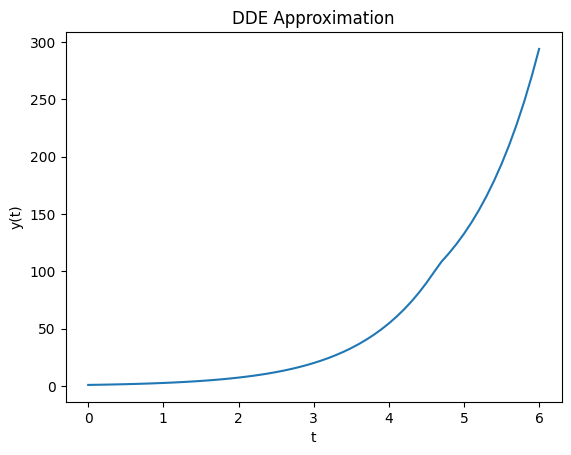

In [1]:
import numpy as np

#======================================================
# 1) HÀM TIỆN ÍCH: LAGRANGE INTERPOLATION TRÊN 4 ĐIỂM
#======================================================
def build_interpolant_4(t_n, h, c_vals, Y_vals):
    """
    Trả về một HÀM p(t) = đa thức Lagrange bậc 3,
    nội suy qua 4 điểm (c_i, Y_i) với c_i (trong [0,1]) và Y_i trong R^d.
    
    Thực chất, ta sẽ nội suy theo biến theta = (t - t_n)/h,
    rồi "gói" thành hàm p(t) để tiện gọi.

    Tham số:
      - t_n  : thời điểm đầu đoạn
      - h    : độ dài bước
      - c_vals : mảng 1D (4 phần tử) các c_i (0 <= c_1 < c_2 < c_3 < 1)
      - Y_vals : mảng 2D shape (4, d) các vector Y_i tương ứng

    Trả về:
      - p(t): hàm Python nhận t, trả về giá trị nội suy trong R^d
    """
    # Lưu c và Y dưới dạng numpy
    c = np.array(c_vals, dtype=float)
    Y = np.array(Y_vals, dtype=float)  # shape (4, d)
    
    # Hàm Lagrange cơ bản: L_i(theta) = Π_{j!=i} ( (theta - c_j)/(c_i - c_j) )
    # Ta xây luôn cho 4 i = 0..3
    # Tính trước hệ số L_i để không phải tính nhiều lần.
    
    def lagrange_basis(theta, i):
        """Tính L_i(theta) cho i = 0..3."""
        num = 1.0
        den = 1.0
        for j in range(4):
            if j != i:
                num *= (theta - c[j])
                den *= (c[i] - c[j])
        return num / den
    
    def p(t):
        """Trả về giá trị nội suy tại t (một vector R^d)."""
        theta = (t - t_n) / h  # biến cục bộ trong [0,1]
        val = np.zeros_like(Y[0])
        for i in range(4):
            Li = lagrange_basis(theta, i)
            val += Li * Y[i]
        return val
    
    return p

#======================================================
# 2) HÀM TIỆN ÍCH: TÌM y(xi) = NỘI SUY TRÊN ĐOẠN PHÙ HỢP
#======================================================
def get_y_at(xi, segments, phi):
    """
    Tìm giá trị y(xi) bằng cách:
      - Nếu xi < segments[0]['t_start'], dùng hàm lịch sử phi(xi).
      - Ngược lại, tìm đoạn [t_n, t_{n+1}] chứa xi.
        Gọi p_n(t) là nội suy đã lưu, trả về p_n(xi).
    
    segments: list các dict, mỗi dict có:
       {
         't_start': t_n,
         't_end'  : t_{n+1},
         'interp' : hàm p_n(t) trả về y xấp xỉ trên đoạn
       }
    phi: hàm điều kiện đầu, dùng cho t <= t_0
    """
    # Nếu xi < t_0, dùng phi
    if xi < segments[0]['t_start']:
        return phi(xi)
    
    # Tìm đoạn
    # Giả sử segments sắp xếp theo thứ tự t_start tăng dần.
    # Ta duyệt nhị phân hoặc tuyến tính (ở đây làm đơn giản tuyến tính).
    for seg in segments:
        if seg['t_start'] <= xi <= seg['t_end']:
            return seg['interp'](xi)
    
    # Nếu xi lớn hơn t_end của đoạn cuối cùng, có thể do vượt t_f
    # Ở đây ta cho "bó tay" hoặc trả về giá trị cuối cùng
    # Tuỳ cách bạn muốn xử lý
    return segments[-1]['interp'](segments[-1]['t_end'])


#======================================================
# 3) HÀM GIẢI DDE BẰNG PHƯƠNG PHÁP BOGACKI–SHAMPINE (bậc 3)
#    VÀ NỘI SUY LOẠI 1 (đa thức Lagrange) TRÊN MỖI ĐOẠN
#======================================================
def solve_dde(f, tau, phi, t0, tf, y0=None, h=0.1, max_steps=10000):
    """
    Giải gần đúng DDE:
       y'(t) = f(t, y(t), y(t - tau(t, y(t)))),
       y(t)  = phi(t), t <= t0,
    trên [t0, tf] bằng Bogacki–Shampine 4-stage (bậc 3) + nội suy đa thức bậc 3.
    
    Tham số:
      - f   : hàm f(t, y, y_delay) -> R^d
      - tau : hàm tau(t, y) -> float (độ trễ)
      - phi : hàm phi(t) -> R^d (đk lịch sử)
      - t0, tf : khoảng thời gian [t0, tf]
      - y0  : vector R^d, giá trị y(t0). Nếu None, tự phi(t0).
      - h   : bước thời gian cố định (có thể thay đổi linh hoạt).
      - max_steps : giới hạn số bước để tránh vòng lặp vô hạn.
    
    Trả về:
      - times     : list thời điểm lưới
      - values    : list xấp xỉ nghiệm tại times (cùng shape với y0)
      - segments  : list chứa nội suy trên mỗi đoạn
    """
    # Nếu y0 không có, lấy từ phi(t0)
    if y0 is None:
        y0 = phi(t0)
    y0 = np.array(y0, dtype=float)
    
    # Butcher table cho Bogacki–Shampine bậc 3 (4 stage):
    # c = [0, 1/2, 3/4, 1]
    # a = [
    #   [0,   0,   0,   0  ],
    #   [1/2, 0,   0,   0  ],
    #   [0,   3/4, 0,   0  ],
    #   [2/9, 1/3, 4/9, 0  ]
    # ]
    # b = [2/9, 1/3, 4/9, 0]   (dùng cho y_{n+1}, bậc 3)
    # => Y_4 = y_n + h*(2/9 k1 + 1/3 k2 + 4/9 k3)  (chính là y_{n+1})
    # k4 chỉ dùng cho embedded 2nd order, ở đây ta không dùng b4 = 0.
    
    c = np.array([0.0, 0.5, 0.75, 1.0])
    a = np.array([
        [0.0,   0.0,  0.0, 0.0],
        [0.5,   0.0,  0.0, 0.0],
        [0.0,  0.75,  0.0, 0.0],
        [2/9,  1/3,  4/9,  0.0]
    ])
    b = np.array([2/9, 1/3, 4/9, 0.0])  # Hệ số để tính y_{n+1}
    
    # Khởi tạo
    t_n = t0
    y_n = y0
    times = [t_n]
    values = [y_n]
    
    # segments sẽ lưu các dict:
    #   {
    #     't_start': t_n,
    #     't_end'  : t_{n+1},
    #     'interp' : hàm p_n(t)
    #   }
    segments = []
    
    step_count = 0
    while t_n < tf and step_count < max_steps:
        # Điều chỉnh h nếu bước cuối vượt tf
        if t_n + h > tf:
            h = tf - t_n
            if h <= 1e-15:
                break
        
        #==================================================
        # Tính các stage k1, k2, k3, k4
        #==================================================
        k = []
        Y_stage = []
        
        for i in range(4):
            # t_{n,i} = t_n + c[i]*h
            t_ni = t_n + c[i]*h
            
            # Y_i = y_n + h * sum_{j=0..i-1} a[i,j]*k[j]
            # (Bogacki–Shampine explicit => có thể tính tuần tự)
            if i == 0:
                Y_i = y_n  # do a[0,:] = 0
            else:
                sum_ak = np.zeros_like(y_n)
                for j in range(i):
                    sum_ak += a[i,j] * k[j]
                Y_i = y_n + h * sum_ak
            
            # Tính độ trễ:
            delay_i = tau(t_ni, Y_i)
            xi = t_ni - delay_i
            
            # Lấy y(xi):
            if xi < t0:
                y_delay = phi(xi)
            else:
                y_delay = get_y_at(xi, segments, phi)
            
            # Đạo hàm
            k_i = f(t_ni, Y_i, y_delay)
            
            k.append(k_i)
            Y_stage.append(Y_i)
        
        #==================================================
        # Tính y_{n+1} = Y_4 (vì b4=0, Y_4 = y_n + h*(2/9 k1 + 1/3 k2 + 4/9 k3))
        #==================================================
        # Y_4 thực ra ta đã tính ở i=3:
        #   Y_4 = y_n + h * (2/9 k1 + 1/3 k2 + 4/9 k3)
        # (Trong code: Y_stage[3])
        y_np1 = Y_stage[3]
        
        t_np1 = t_n + h
        
        #==================================================
        # Xây dựng nội suy Lagrange bậc 3 trên 4 điểm:
        #   (c[0], Y_stage[0]) = (0,   Y_1 = y_n)
        #   (c[1], Y_stage[1]) = (0.5, Y_2)
        #   (c[2], Y_stage[2]) = (0.75,Y_3)
        #   (c[3], Y_stage[3]) = (1,   Y_4 = y_{n+1})
        #==================================================
        c_local = c  # [0, 0.5, 0.75, 1.0]
        Y_local = Y_stage  # 4 vectors
        
        interp_func = build_interpolant_4(t_n, h, c_local, Y_local)
        
        # Lưu đoạn
        segments.append({
            't_start': t_n,
            't_end'  : t_np1,
            'interp' : interp_func
        })
        
        # Cập nhật
        t_n = t_np1
        y_n = y_np1
        
        times.append(t_n)
        values.append(y_n)
        
        step_count += 1
    
    return np.array(times), np.array(values), segments

#======================================================
# 4) VÍ DỤ MINH HỌA CÁCH SỬ DỤNG
#======================================================
if __name__ == "__main__":
    # Ví dụ: giải một DDE đơn giản
    #   y'(t) = -lambda * y(t) + alpha * y(t - tau_const)
    #   y(t)  = phi(t) = sin(t) (giả sử) cho t <= 0
    # (chỉ minh họa, không nhất thiết có nghiệm giải tích đơn giản)
    
    def f_example(t, y, y_delay):
        # ví dụ đơn giản: y, y_delay là mảng 1D shape=(1,)
        return np.array([ np.exp(t) + (y_delay[0] - np.exp(t-1)) ])
    
    def tau_example(t, y):
        # trễ = 1 + (y[0] - e^t)^2
        return 1.0 + (y[0] - np.exp(t))**2
    
    def phi_example(t):
        # hàm lịch sử, e^t
        return np.array([ np.exp(t) ])
    
    t0 = 0.0
    tf = 6
    y0 = phi_example(t0) 
    
    # Giải DDE
    times, values, segments = solve_dde(
        f = lambda t,u,v: f_example(t,u,v),
        tau = tau_example,
        phi = phi_example,
        t0 = t0,
        tf = tf,
        y0 = y0,
        h = 0.1
    )
    
    # In kết quả tại một số điểm
    print("Số bước =", len(times)-1)
    for i in range(0, len(times), 10):
        print(f"t = {times[i]:.2f},  y = {values[i][0]:.6f}")
    
    # Thử nội suy tại t = 2.345
    t_query = 2.345
    y_query = get_y_at(t_query, segments, phi_example)
    print(f"\nNội suy tại t = {t_query:.3f} => y ~ {y_query[0]:.6f}")
# vẽ đồ thị nghiệm xấp xỉ
import matplotlib.pyplot as plt
plt.xlabel("t")
plt.ylabel("y(t)")
plt.title("DDE Approximation")
plt.plot(times, values, label="Approximation")

In [24]:
abs(values[-1]-y_exact(6))/y_exact(6)

array([0.27140888])

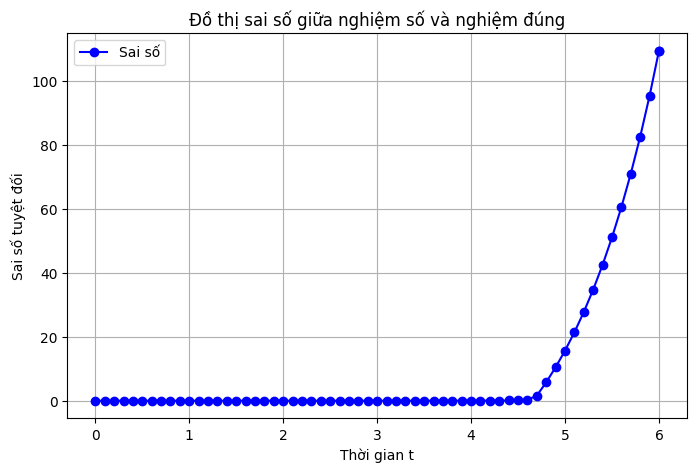

In [2]:
def y_exact(t):
    return np.e**t
exact_values = np.array([y_exact(t) for t in times])
values_1d = values.flatten()
errors = np.abs(values_1d - exact_values)

# Nếu values có dạng vector 2D (mỗi giá trị là np.array([y])):
# exact_values = np.array([y_exact(t) for t in times])
# errors = np.abs(exact_values - np.array([v[0] for v in values]))

# Vẽ đồ thị sai số:
plt.figure(figsize=(8, 5))
plt.plot(times, errors, marker='o', linestyle='-', color='blue', label='Sai số')
plt.xlabel('Thời gian t')
plt.ylabel('Sai số tuyệt đối')
plt.title('Đồ thị sai số giữa nghiệm số và nghiệm đúng')
plt.legend()
plt.grid(True)
plt.show()


Số bước = 660
t = 0.000, y = 1.000000
t = 1.432, y = 4.185315
t = 2.312, y = 10.089712
t = 3.125, y = 22.754247
t = 3.797, y = 44.586070
t = 4.310, y = 74.434266
t = 4.753, y = 115.878704
t = 5.112, y = 165.954262
t = 5.449, y = 232.497298
t = 5.728, y = 307.503632
t = 6.000, y = 403.425673


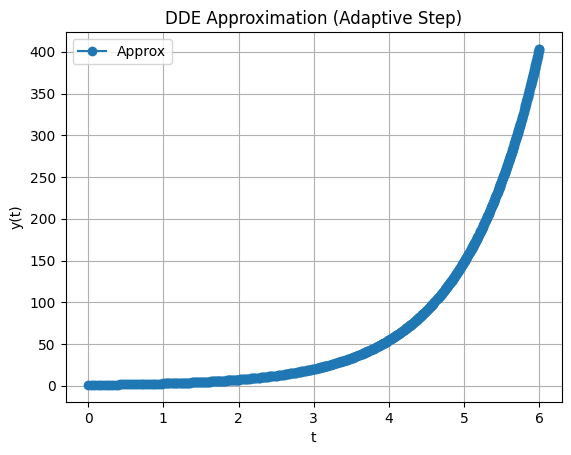

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#======================================================
# 1) HÀM TIỆN ÍCH: LAGRANGE INTERPOLATION TRÊN 4 ĐIỂM
#======================================================
def build_interpolant_4(t_n, h, c_vals, Y_vals):
    """
    Trả về một HÀM p(t) = đa thức Lagrange bậc 3,
    nội suy qua 4 điểm (c_i, Y_i) với c_i (trong [0,1]) và Y_i trong R^d.
    
    Ta sẽ nội suy theo biến theta = (t - t_n)/h,
    rồi "gói" thành hàm p(t) để tiện gọi.
    """
    c = np.array(c_vals, dtype=float)
    Y = np.array(Y_vals, dtype=float)  # shape (4, d) hoặc (4,) nếu vô hướng
    
    def lagrange_basis(theta, i):
        """Tính L_i(theta) cho i = 0..3."""
        num = 1.0
        den = 1.0
        for j in range(4):
            if j != i:
                num *= (theta - c[j])
                den *= (c[i] - c[j])
        return num / den
    
    def p(t):
        """Trả về giá trị nội suy tại t (vector hoặc scalar)."""
        theta = (t - t_n) / h
        val = np.zeros_like(Y[0])
        for i in range(4):
            Li = lagrange_basis(theta, i)
            val += Li * Y[i]
        return val
    
    return p

#======================================================
# 2) HÀM TIỆN ÍCH: TÌM y(xi) = NỘI SUY TRÊN ĐOẠN PHÙ HỢP
#======================================================
def get_y_at(xi, segments, phi):
    """
    Tìm giá trị y(xi) bằng cách:
      - Nếu xi < segments[0]['t_start'], dùng hàm lịch sử phi(xi).
      - Ngược lại, tìm đoạn [t_n, t_{n+1}] chứa xi,
        gọi p_n(t) là nội suy đã lưu, trả về p_n(xi).
    """
    if xi < segments[0]['t_start']:
        return phi(xi)
    
    # Tìm đoạn
    for seg in segments:
        if seg['t_start'] <= xi <= seg['t_end']:
            return seg['interp'](xi)
    
    # Nếu xi > t_end của đoạn cuối
    return segments[-1]['interp'](segments[-1]['t_end'])

#======================================================
# 3) GIẢI DDE VỚI BƯỚC THÍCH NGHI BẰNG BOGACKI–SHAMPINE
#    + NỘI SUY LOẠI 1 (đa thức Lagrange)
#======================================================
def solve_dde_adaptive(f, tau, phi, t0, tf, y0=None, 
                       h_init=0.1, tol=1e-6, max_steps=10000):
    """
    Giải gần đúng DDE:
       y'(t) = f(t, y(t), y(t - tau(t, y(t)))),
       y(t)  = phi(t), t <= t0,
    trên [t0, tf] bằng Bogacki–Shampine (bậc 3) với embedded bậc 2 để 
    ước lượng sai số cục bộ và điều chỉnh bước.
    
    Tham số:
      - f   : hàm f(t, y, y_delay) -> R^d
      - tau : hàm tau(t, y) -> float
      - phi : hàm phi(t) -> R^d (đk lịch sử)
      - t0, tf : khoảng thời gian [t0, tf]
      - y0  : vector (hoặc scalar) R^d, giá trị y(t0). Nếu None, lấy phi(t0).
      - h_init   : bước ban đầu
      - tol      : ngưỡng sai số cục bộ (relative hoặc absolute tuỳ ý)
      - max_steps: giới hạn số bước để tránh vòng lặp vô hạn
    
    Trả về:
      - times     : list thời điểm lưới (numpy array)
      - values    : list xấp xỉ nghiệm tại times (cùng shape với y0)
      - segments  : list chứa nội suy trên mỗi đoạn
    """
    if y0 is None:
        y0 = phi(t0)
    y0 = np.array(y0, dtype=float)
    
    # Butcher table Bogacki–Shampine (4 stage):
    # c = [0, 1/2, 3/4, 1]
    # a = [
    #   [0,   0,   0,   0  ],
    #   [1/2, 0,   0,   0  ],
    #   [0,   3/4, 0,   0  ],
    #   [2/9, 1/3, 4/9, 0  ]
    # ]
    # b (order=3)    = [2/9, 1/3, 4/9, 0   ]
    # b_star (order=2) = [7/24, 1/4, 1/3, 1/8]
    # => Y_4 = y_n + h*(2/9 k1 + 1/3 k2 + 4/9 k3)
    
    c = np.array([0.0, 0.5, 0.75, 1.0])
    a = np.array([
        [0.0,   0.0,  0.0,  0.0],
        [0.5,   0.0,  0.0,  0.0],
        [0.0,  0.75,  0.0,  0.0],
        [2/9,  1/3,  4/9,  0.0]
    ])
    b_3 = np.array([2/9, 1/3, 4/9, 0.0])      # bậc 3
    b_2 = np.array([7/24, 1/4, 1/3, 1/8])     # bậc 2 (embedded)
    p = 3  # bậc chính (3)
    
    # Tham số cho thích nghi
    safety = 0.9
    max_factor = 2.0
    min_factor = 0.2
    
    # Khởi tạo
    t_n = t0
    y_n = y0
    h = h_init
    
    times = [t_n]
    values = [y_n]
    segments = []
    
    step_count = 0
    while t_n < tf and step_count < max_steps:
        
        if t_n + h > tf:
            h = tf - t_n  # rút ngắn bước cuối
        
        #--------------------------
        # Vòng lặp thử bước
        #--------------------------
        while True:
            # Tính các stage k1..k4
            k = []
            Y_stage = []
            for i in range(4):
                t_ni = t_n + c[i]*h
                if i == 0:
                    Y_i = y_n
                else:
                    sum_ak = np.zeros_like(y_n)
                    for j in range(i):
                        sum_ak += a[i,j]*k[j]
                    Y_i = y_n + h*sum_ak
                
                # Tính độ trễ
                delay_i = tau(t_ni, Y_i)
                xi = t_ni - delay_i
                
                if xi < t0:
                    y_delay = phi(xi)
                else:
                    y_delay = get_y_at(xi, segments, phi)
                
                k_i = f(t_ni, Y_i, y_delay)
                k.append(k_i)
                Y_stage.append(Y_i)
            
            # Nghiệm bậc 3
            y_3rd = y_n + h * np.sum([b_3[i]*k[i] for i in range(4)], axis=0)
            # Nghiệm bậc 2 (embedded)
            y_2nd = y_n + h * np.sum([b_2[i]*k[i] for i in range(4)], axis=0)
            
            # Sai số cục bộ ước lượng
            err_vec = y_3rd - y_2nd
            err_est = np.linalg.norm(err_vec, ord=np.inf)  # hoặc L2, v.v.
            
            # Độ lớn nghiệm để scale (nếu muốn relative error)
            # Ở đây làm đơn giản: so sánh tuyệt đối với tol
            if err_est < tol:
                # Thành công: chấp nhận bước
                t_np1 = t_n + h
                y_np1 = y_3rd  # bậc 3
                
                # Xây dựng nội suy bậc 3
                # (c[0], Y_stage[0]) = (0, y_n)
                # (c[1], Y_stage[1]) = (0.5, ...)
                # ...
                # (c[3], y_3rd)
                Y_stage[3] = y_3rd  # thay Y_4 = nghiệm bậc 3
                interp_func = build_interpolant_4(t_n, h, c, Y_stage)
                
                segments.append({
                    't_start': t_n,
                    't_end':   t_np1,
                    'interp':  interp_func
                })
                
                t_n = t_np1
                y_n = y_np1
                times.append(t_n)
                values.append(y_n)
                
                #-----------------------------------
                # Tính bước tiếp theo h_new
                #-----------------------------------
                if err_est < 1e-30:
                    # tránh chia 0 => cho h_new = 2*h (hoặc max_factor * h)
                    h_new = h * max_factor
                else:
                    # bậc p=3 => sai số cục bộ ~ O(h^(p+1)), 
                    # => h_{n+1} ~ h_n * (tol / err_est)^(1/(p+1))
                    h_new = safety * h * (tol / err_est)**(1.0/(p+1))
                
                # kẹp h_new vào [min_factor*h, max_factor*h]
                h_new = max(h_new, min_factor*h)
                h_new = min(h_new, max_factor*h)
                
                h = h_new
                break  # thoát while True => sang bước tiếp
            else:
                # Sai số quá lớn => giảm h, thử lại
                h_new = safety * h * (tol / err_est)**(1.0/(p+1))
                h_new = max(h_new, min_factor*h)  # không giảm quá min_factor
                h = h_new
                # lặp while True với h mới (cùng t_n, y_n)
                # (chưa tăng step_count, vì chưa chấp nhận bước)
        
        step_count += 1
        if t_n >= tf:
            break
    
    return np.array(times), np.array(values), segments

#======================================================
# 4) VÍ DỤ SỬ DỤNG
#======================================================
if __name__ == "__main__":
    # Bài toán DDE minh hoạ:
    #   y'(t) = f_example(t, y(t), y(t - tau(t,y(t))))
    #   y(t)  = phi_example(t), t <= 0
    # Ta thử 1 ví dụ "giả lập", trễ phụ thuộc y
    
    def f_example(t, y, y_delay):
        # ví dụ đơn giản: y, y_delay là mảng 1D shape=(1,)
        return np.array([ np.exp(t) + (y_delay[0] - np.exp(t-1)) ])
    
    def tau_example(t, y):
        # trễ = 1 + (y[0] - e^t)^2
        return 1.0 + (y[0] - np.exp(t))**2
    
    def phi_example(t):
        # hàm lịch sử, e^t
        return np.array([ np.exp(t) ])
    
    t0 = 0.0
    tf = 6.0
    y0 = phi_example(t0)
    
    # Giải DDE với bước thích nghi
    times, values, segments = solve_dde_adaptive(
        f   = f_example,
        tau = tau_example,
        phi = phi_example,
        t0  = t0,
        tf  = tf,
        y0  = y0,
        h_init = 0.1,   # bước ban đầu
        tol    = 1e-6   # ngưỡng sai số cục bộ
    )
    
    print("Số bước =", len(times)-1)
    for i in range(0, len(times), max(1, len(times)//10)):
        print(f"t = {times[i]:.3f}, y = {values[i][0]:.6f}")
    
    # Vẽ nghiệm xấp xỉ
    plt.figure()
    plt.plot(times, [v[0] for v in values], 'o-', label="Approx")
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.title("DDE Approximation (Adaptive Step)")
    plt.grid(True)
    plt.legend()
    plt.show()


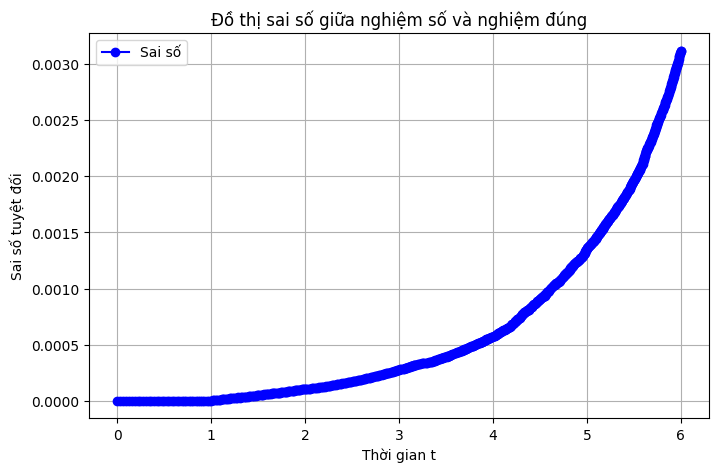

In [16]:
def y_exact(t):
    return np.e**t
exact_values = np.array([y_exact(t) for t in times])
values_1d = values.flatten()
errors = np.abs(values_1d - exact_values)

# Nếu values có dạng vector 2D (mỗi giá trị là np.array([y])):
# exact_values = np.array([y_exact(t) for t in times])
# errors = np.abs(exact_values - np.array([v[0] for v in values]))

# Vẽ đồ thị sai số:
plt.figure(figsize=(8, 5))
plt.plot(times, errors, marker='o', linestyle='-', color='blue', label='Sai số')
plt.xlabel('Thời gian t')
plt.ylabel('Sai số tuyệt đối')
plt.title('Đồ thị sai số giữa nghiệm số và nghiệm đúng')
plt.legend()
plt.grid(True)
plt.show()


In [17]:
h_values = np.diff(times)
h_min = np.min(h_values)
h_max = np.max(h_values)
h_max, h_min, len(times)

(np.float64(0.03363159901076028), np.float64(0.0013237883656014304), 661)